# Comments start in the 'Cosmic Dispersion' section

# Load Modules

In [1]:
%matplotlib notebook
import pickle
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
plt.ioff()
import matplotlib.patches as mpatches
from astropy.io.votable import parse
from astropy.table import vstack
from matplotlib.collections import LineCollection
from matplotlib.ticker import FuncFormatter
from numpy import log10 as log
from numpy import log as ln
def scientific_notation(x, pos):return "${:.1e}$".format(x).replace("e+0","e")

# Load DR3 & filtering results

In [2]:
cns=parse('cns.vot').resources[0].tables[0].to_table()

try:ta1,ta2
except:
    ta1=parse('ucd.vot').resources[0].tables[0].to_table()
    ta2=parse('car.vot').resources[0].tables[0].to_table()
tab=vstack([ta1,ta2])

ruw=dict(zip(tab['source_id'],tab['ruwe']))
grp=dict(zip(tab['source_id'],tab['g_rp']))
rpm=dict(zip(tab['source_id'],tab['phot_rp_mean_mag']))
gmm=dict(zip(tab['source_id'],tab['phot_g_mean_mag']))
par=dict(zip(tab['source_id'],tab['parallax']))
p_e=dict(zip(tab['source_id'],tab['parallax_error']))

dr3={'grp':grp,'rpm':rpm,'par':par,'par_err':p_e,'gmm':gmm,'ruw':ruw}

with open('dic.pickle','rb') as f:dic=pickle.load(f)
with open('spe.pickle','rb') as f:spe_55,err_55=pickle.load(f)

# CAMD

<IPython.core.display.Javascript object>


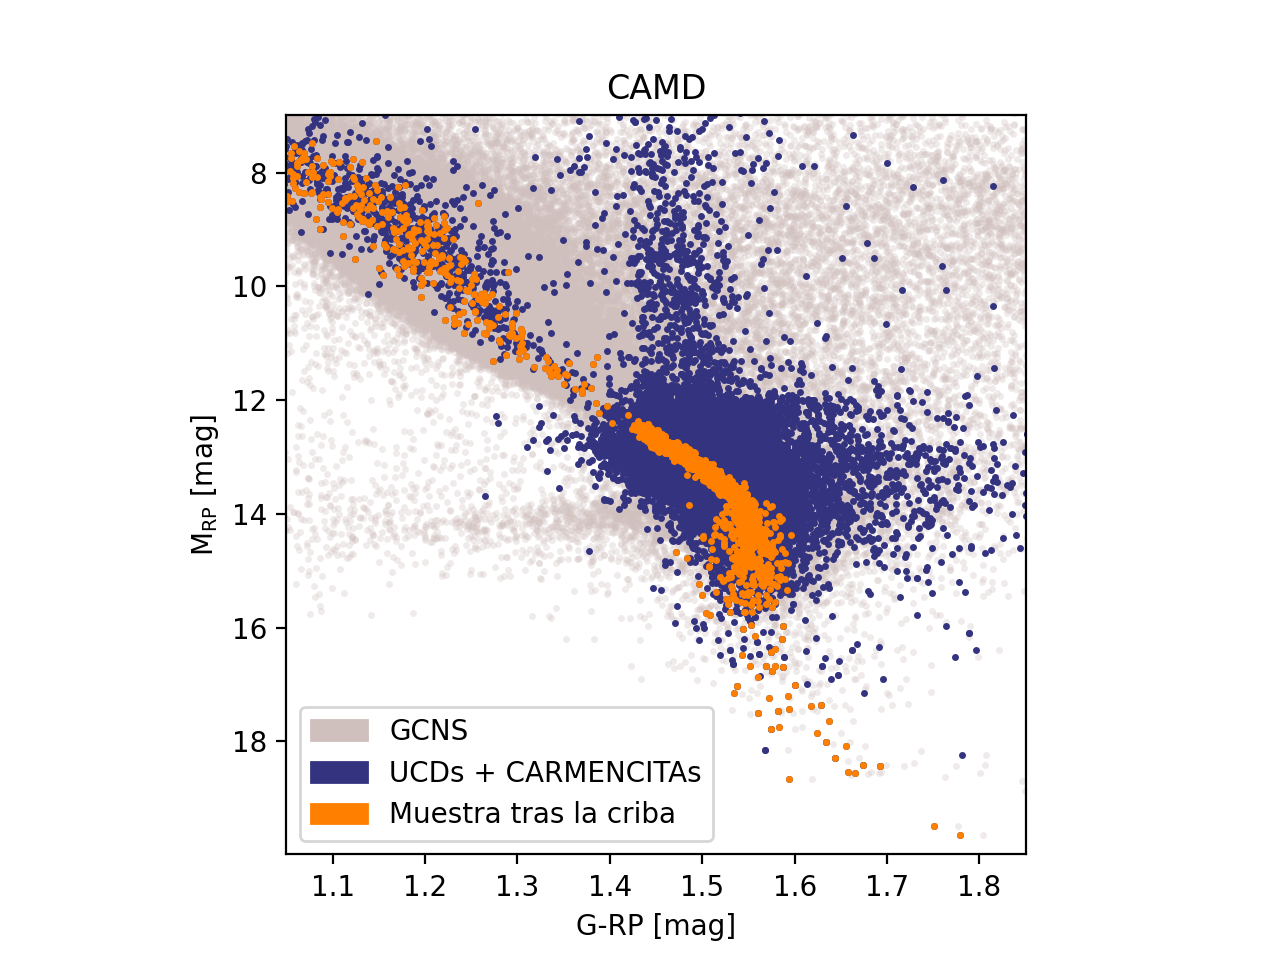

In [3]:
fig,ax=plt.subplots()
yax=cns['phot_rp_mean_mag'].data.data-10+5*log(cns['parallax'].data.data)
plt.plot(cns['g_rp'].data.data,yax,'o',alpha=.3,markeredgewidth=0,markersize=2.5,color='#d0c0bd', zorder=0)
yax=tab['phot_rp_mean_mag'].data.data-10+5*log(tab['parallax'].data.data)
plt.plot(tab['g_rp'].data.data,yax,'o',markeredgewidth=0,markersize=2.5,color='#333380')
dat=[(dr3['grp'][id_],dr3['rpm'][id_]-10+5*log(dr3['par'][id_]))for typ in dic if dic[typ]is not None for id_ in dic[typ]]
plt.plot([sou[0]for sou in dat],[sou[1]for sou in dat],'o',markeredgewidth=0,markersize=2.5,color='#ff8000')
plt.title('CAMD');plt.xlabel('G-RP [mag]');plt.ylabel(r'M$_{\rm RP}$ [mag]')
ax.set_xlim(1.05,1.85);ax.set_ylim(19.99,6.99);ax.set_aspect(1.0/ax.get_data_ratio(),adjustable='box')
a=mpatches.Patch(color='#d0c0bd',label='GCNS')
b=mpatches.Patch(color='#333380',label='UCDs + CARMENCITAs')
c=mpatches.Patch(color='#ff8000',label='Muestra tras la criba')
plt.legend(handles=[a,b,c])
plt.show()


# Median(Filtered) = Base

<IPython.core.display.Javascript object>


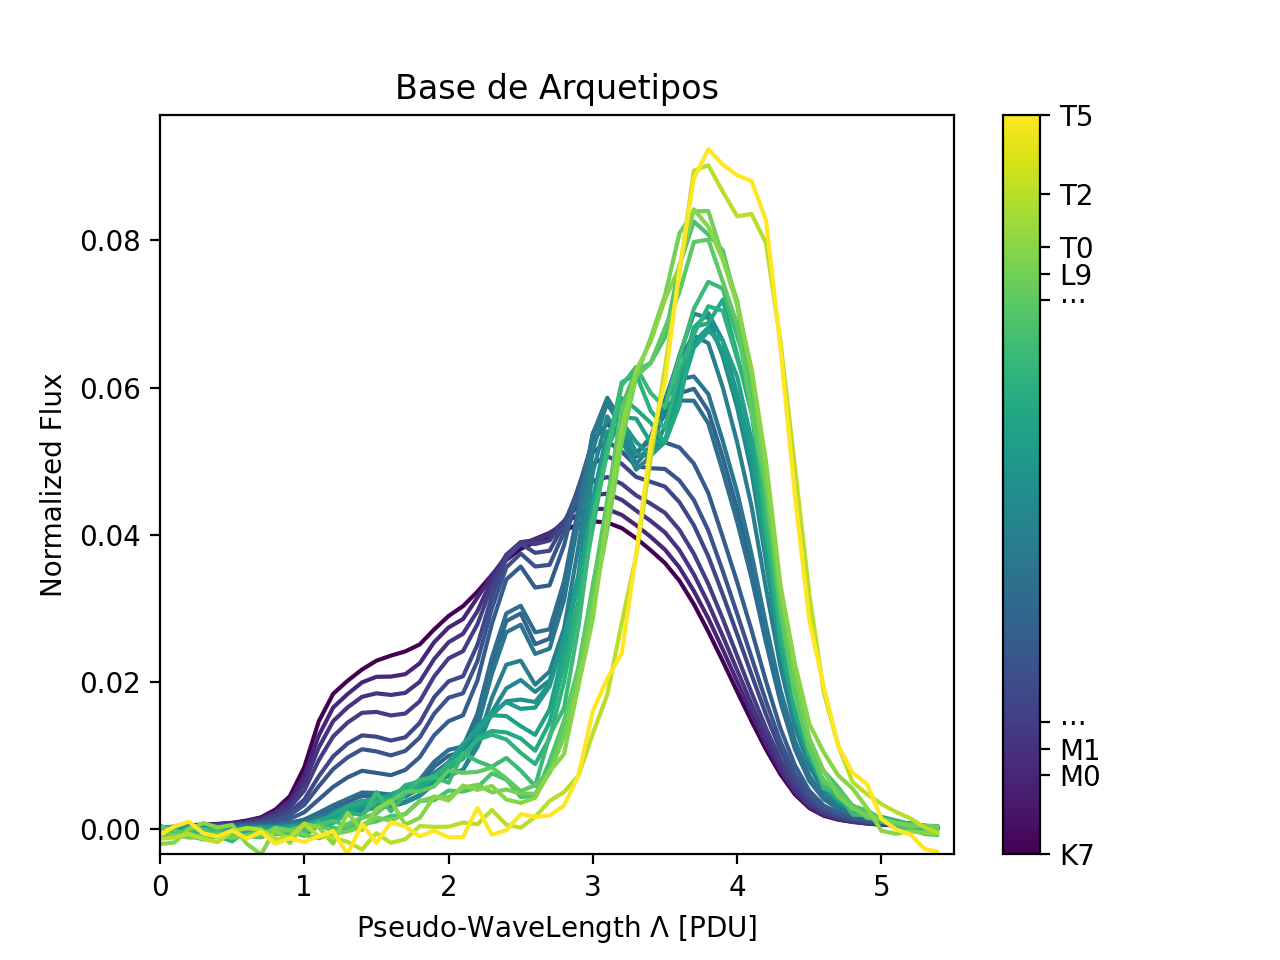

In [4]:
fig,ax=plt.subplots()
xax=0.1*np.array(range(len(spe_55[list(spe_55.keys())[0]])))
bas={typ:None if dic[typ]is None else np.median([spe_55[id_]*1e4/par[id_]**2 for id_ in dic[typ]],axis=0)for typ in dic}
yxs=[bas[typ]/sum(bas[typ])for typ in bas if bas[typ]is not None]
line_segments=LineCollection([np.column_stack([xax,yax])for yax in yxs],array=[ind for ind,typ in enumerate(dic.keys())if bas[typ]is not None])
ax.add_collection(line_segments)
axcb=fig.colorbar(line_segments,ticks=[0,3,4,5,21,22,23,25,28])
axcb.ax.set_yticklabels(['K7','M0','M1','···','···','L9','T0','T2','T5']) 
ax.set_title('Base de Arquetipos')
plt.xlabel(r'Pseudo-WaveLength $\Lambda$ [PDU]');plt.ylabel('Normalized Flux')
ax.set_xlim(0,5.5);ax.set_ylim(np.min(yxs),np.max(yxs)*1.05)
plt.show()


# Cosmic Dispersion

<IPython.core.display.Javascript object>


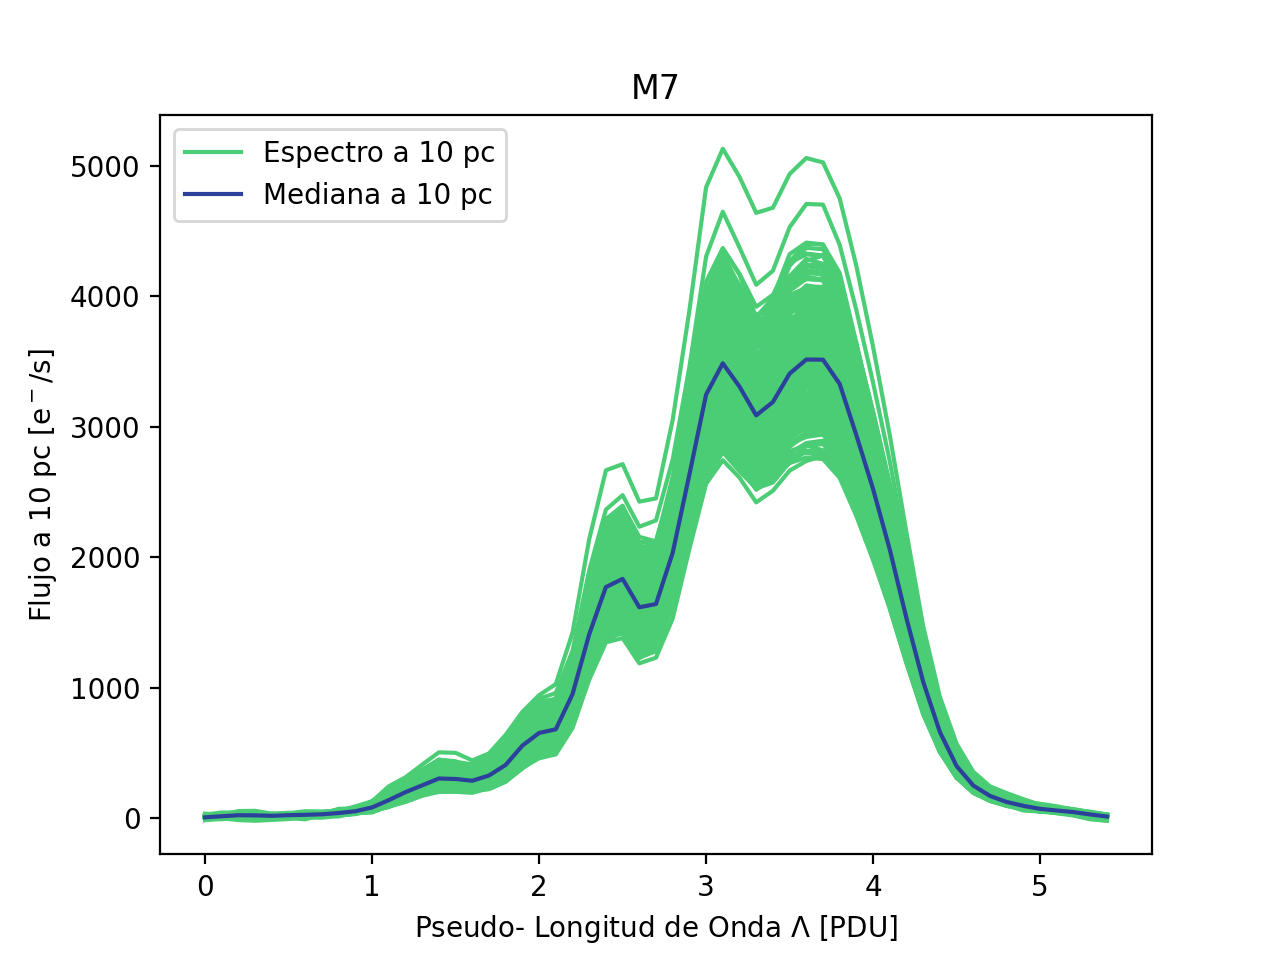

<IPython.core.display.Javascript object>


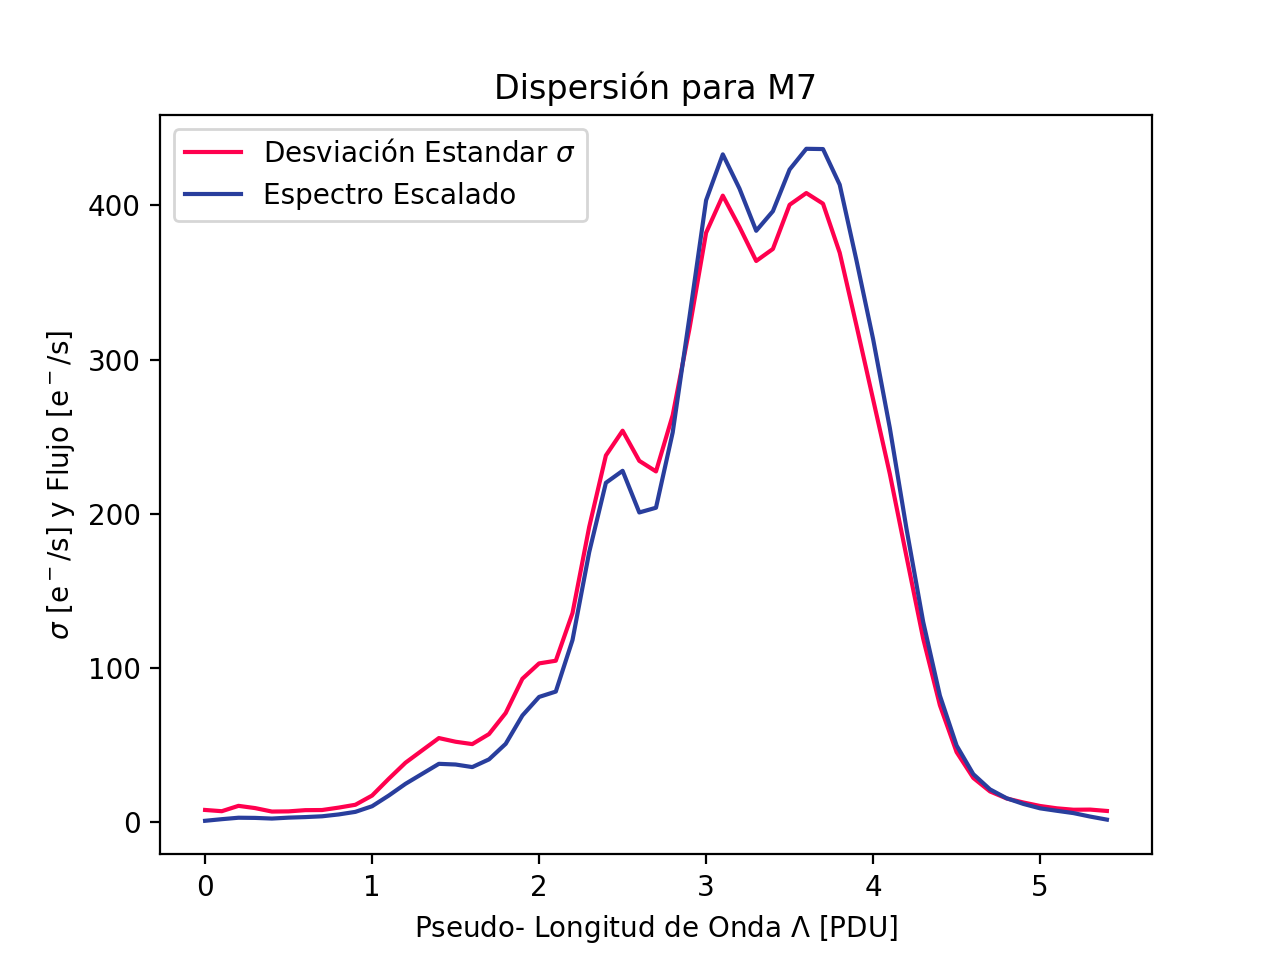

In [5]:
# Calcularé desviaciones estandar std
std={}

# Calcularé el factor que escale el elemento de la base a la función de desviación estandar
fac={}

# Para cada tipo espectral
for typ in dic:
    if dic[typ]:
        
        # Aquí guardaré la desviación estandar para este tipo espectral
        std[typ]=[]

        # Represento los datos
        if typ=='M7':
            fig,ax=plt.subplots()
            for id_ in dic[typ]:ax.plot(xax,spe_55[id_]*1e4/dr3['par'][id_]**2,color='#4bcd76')
            ax.plot(xax,spe_55[id_]*1e4/dr3['par'][id_]**2,color='#4bcd76',label='Espectro a 10 pc')
            ax.plot(xax,bas[typ],label='Mediana a 10 pc',color='#2b419b')
            plt.legend()
            plt.xlabel(r'Pseudo- Longitud de Onda $\Lambda$ [PDU]');plt.ylabel(r'Flujo a 10 pc [e$^-$/s]')
            ax.set_title(typ)
            plt.show()

        # Para cada pseudo- longitud de onda lmd
        for lmb in range(55):

            # Guardaré en dat los flujos para esta pseudo- longitud de onda lmd
            dat=[]

            # Para cada espectro RP
            for id_ in dic[typ]:

                # Leo el flujo
                flx=spe_55[id_][lmb]

                # Leo la paralaje
                par=dr3['par'][id_]

                # Corrijo el flujo en distancia
                flx=flx*1e4/par**2

                # Guardo el resultado en dat
                dat.append(flx)

            # Calculo la desviación estandar de todos los datos para esta lmd
            std_lmd=np.std(dat)

            # Guardo el resultado en std[typ]
            std[typ].append(std_lmd)

        # Calculo el factor de escala
        fac[typ]=np.sum(std[typ])/np.sum(bas[typ])
        
        # Represento la función de desviación estandar std y el elemento de la base escalado
        if typ=='M7':
            fig,ax=plt.subplots()
            plt.plot(xax,std[typ],color='#ff004e',label=r'Desviación Estandar $\sigma$')
            plt.plot(xax,bas[typ]*fac[typ],color='#293e9d',label='Espectro Escalado')
            plt.xlabel(r'Pseudo- Longitud de Onda $\Lambda$ [PDU]')
            plt.ylabel(r'$\sigma$ [e$^-$/s] y Flujo [e$^-$/s]')
            ax.set_title('Dispersión para '+typ)
            plt.legend()
            plt.show()


<IPython.core.display.Javascript object>


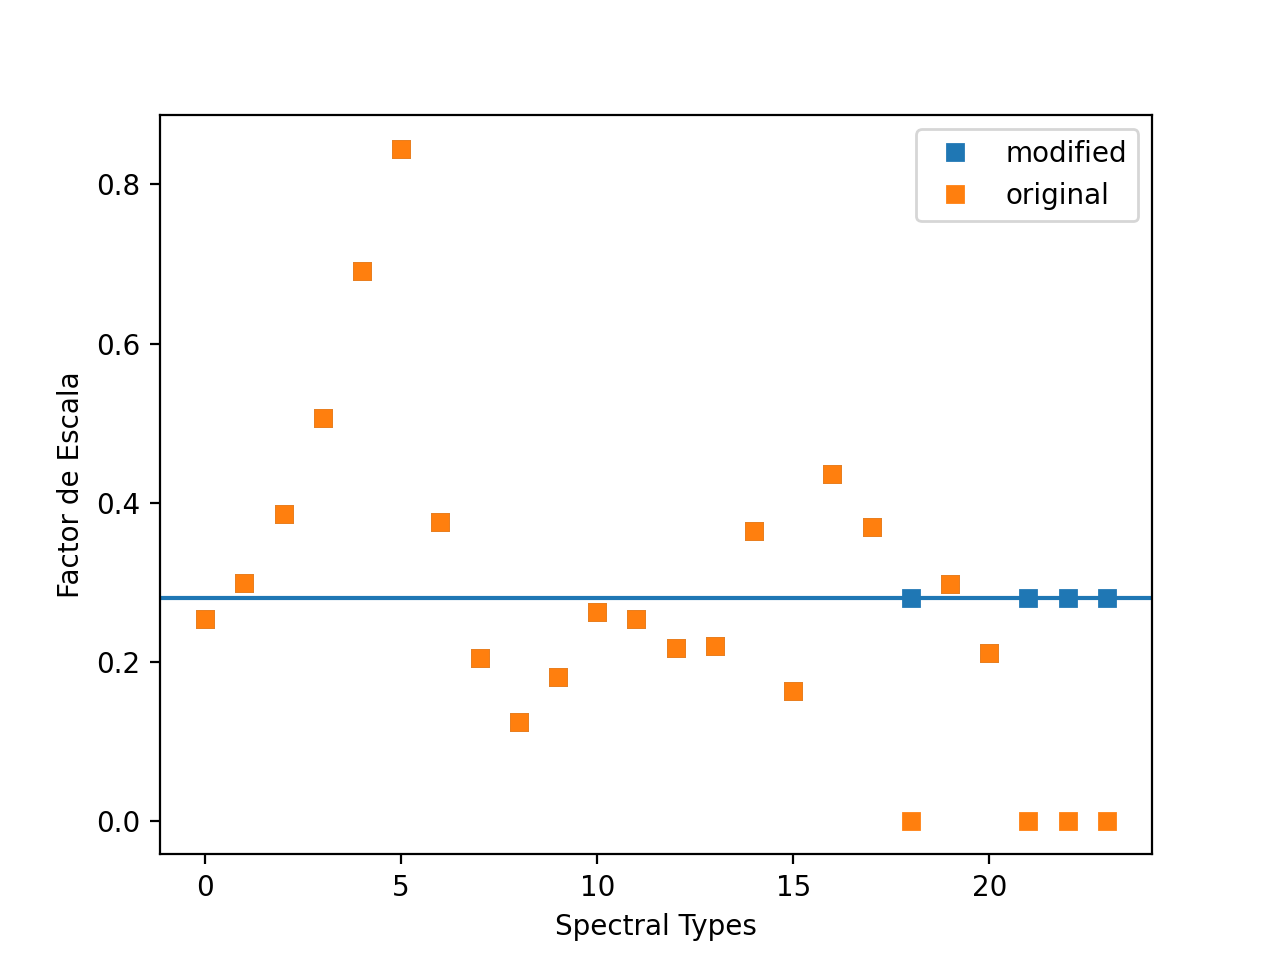

In [6]:
# Use median of factors to estimate std when this cannot be calculated
fig,ax=plt.subplots()
mdn=np.median([fac[typ] for typ in fac if fac[typ] is not None and fac[typ]!=0])
sig=[fac[typ]if fac[typ]!=0 else mdn for typ in fac]
plt.plot(range(len(fac)),sig,'s',label='modified')
plt.plot(range(len(fac)),fac.values(),'s',label='original')
plt.axhline(mdn)
plt.xlabel(r'Spectral Types')
plt.ylabel(r'Factor de Escala')
plt.legend()
plt.show()
try:std['None']
except:
    std={typ:std[typ]if std[typ]is None or fac[typ]!=0 else mdn*bas[typ]for typ in std}
    std['None']=np.zeros_like(std['K7'])
    bas['None']=np.zeros_like(bas['K7'])

# Modelos y sus desviaciones

In [7]:
# Calcular modelos de binaria
bin_sed={}

# Calcular sus desviaciones estandar
bin_std={}

# Para cada tipo espectral de la primaria
for i in std:
    if i:
        bin_sed[i],bin_std[i]={},{}

        # Para cada tipo espectral de la compañera
        for j in std:

            # Evito combinaciones repetidas
            if j==i or j not in bin_sed:

                    # Calculo modelo de binaria como suma de modelos individuales
                    bin_sed[i][j]=bas[i]+bas[j] 

                    # Calculo su desviacion estandar como la suma en cuadratura de la de cada modelo
                    bin_std[i][j]=np.sqrt(np.square(std[i])+np.square(std[j]))


# Get Sigmas

In [8]:
for typ in dic:
    if dic[typ]:
        x=np.average([dr3['gmm'][itm]for itm in dic[typ]])

# Primera aproximación de la Luminosity Function        
luf={}
luf['K7']=0.01
luf['M0']=0.01
luf['M1']=0.01
luf['M2']=0.01
luf['M3']=0.01
luf['M4']=0.008
luf['M5']=0.0045
luf['M6']=0.002
luf['M7']=0.001
luf['M8']=0.0007
luf['M9']=0.00075
luf['L0']=0.001
luf['L1']=0.001
luf['L2']=0.001
luf['L3']=0.001
luf['L4']=0.001
luf['L5']=0.001
luf['L6']=0.001
luf['L7']=0.001
luf['L8']=0.001
luf['L9']=0.001
luf['T0']=0.001
luf['T2']=0.001
luf['T5']=0.001
luf['None']=1

# Factor de normalización para modelos individuales
c4s=sum(luf.values())-1

# Factor de normalización para modelos de binarias
c4b=0
for i in bin_std:
    for j in bin_std[i]:
        if j!='None':
            c4b+=luf[i]*luf[j]
            

# Análisis

In [9]:
# Analizar un RP dado su DR3 ID
def ana(id_):
    z=0
    if dr3['ruw'][id_]>2:

        # Leo el espectro
        spe=spe_55[id_]

        # Leo la paralaje
        par=dr3['par'][id_]

        # Corrijo el flujo en distancia
        flx=spe*1e4/par**2

        # Leo el error en el espectro
        flx_err=err_55[id_]

        # Leo el error en la paralaje
        par_err=dr3['par_err'][id_]

        # Error en el flujo corregido en distancia
        flx_err=np.abs(flx_err*1e4/par**2)+np.abs(par_err*spe*2e4/par**3)

        # Voy a calcular evidencias
        evi={}
        
        # También calcularé distancias (dis) a elementos individuales escalados por un factor (fcs)
        fcs,dis={},{}

        # Para cada modelo
        for i in bin_std:
            if i!='None':
                for j in bin_std[i]:
                    
                        #
                        # Problema de mínimos cuadrados para el cálculo de factores de escala
                        #
                        
                        x=cp.Variable()
                        pro=cp.Problem(cp.Minimize(cp.sum_squares(bas[i]*x-flx)),[x<=10,x>=.1])
                        try:pro.solve()
                        except:pass
                        else:
                            if x.value is not None and x.value<10 and x.value>.1:
                                fcs[i]=x.value
                                dis[pro.value]=i

                                
                        #
                        # Método del factor de Bayes a continuación
                        #
                                
                        # Aproximo el prior como producto del valor de la LF para cada tipo espectral
                        pri=luf[i]*luf[j]
                        if j=='None':pri=pri/c4s
                        else:        pri=pri/c4b

                        # La std es la suma en cuadratura del error en el flujo y la std del modelo
                        std=np.sqrt(np.square(bin_std[i][j])+np.square(flx_err))

                        # Las verosimilitudes responden a una distribución gausiana en torno al modelo
                        ver=np.e**(-0.5*np.square((flx-bin_sed[i][j])/std)-ln(std))

                        # Productorio de verosimilitudes
                        ver=np.prod(ver)

                        # Evidencia es veosimilitud por prior
                        evi_mod=ver*pri

                        # Guardo el resultado
                        evi[evi_mod]=(i,j)

        # Factor de Bayes fac = m_b / m_i
        m_b,m_i=0,0
        for val in evi:
            if evi[val][1]=='None':m_i+=val
            else:m_b+=val
        fac=m_b/m_i
        

        
        #
        # Representación del resultado
        #
        
        try:
            bst_sin=min(dis.keys())
            k=dis[bst_sin]
        except:dis=False
        else:dis=True
        bst_bay=max(evi.keys())
        i,j=evi[bst_bay]
        dis_bay=np.sqrt(np.sum(np.square((flx-bin_sed[i][j]))))
        if dis and not i==j=='K7'and fac>100 and dis_bay*1.1<np.sqrt(bst_sin):
            if True:
                if False:
                    fig,ax=plt.subplots()
                    ax.plot(xax,bin_sed[i][j],color='#00c6ff',label='Modelo '+i+'+'+j)
                    ax.plot(xax,flx,color='#6000c2',label='Espectro a 10 pc',marker='D',markersize=3.5, linestyle='')
                    plt.legend()
                    plt.xlabel(r'Pseudo- Longitud de Onda $\Lambda$ [PDU]');plt.ylabel(r'Flujo a 10 pc [e$^-$/s]')
                    ax.set_title('Gaia DR3 ID: '+str(id_))
                    formatter = FuncFormatter(scientific_notation)
                    ax.yaxis.set_major_formatter(formatter)
                    plt.show()
                if True:
                    fig,ax=plt.subplots()
                    ax.plot(xax,bin_sed[i][j],color='#ff9600',label='Sistema '+i+'+'+j)
                    if i!=j:ax.plot(xax,bas[i],color='#ff9600', linestyle='--',zorder=0,label='Componentes del sist.')
                    else:ax.plot(xax,bas[i],color='#ff9600', linestyle='--',label=i,zorder=0)
                    ax.plot(xax,bas[j],color='#ff9600', linestyle='--',zorder=0)
                    ax.plot(xax,bas[k]*fcs[k],color='#00aaff',label=r'$\gamma\cdot$'+k+' ('+k+' escalada)')
                    if k not in(i,j):ax.plot(xax,bas[k],color='#00aaff',linestyle='--',label=k)
                    s_t=['K7','M0','M1','M2','M3','M4','M5','M6','M7','M8','M9','L0','L1','L2','L3','L4','L5','L6','L7','L8','L9','T0','T2','T5']
                    k=s_t.index(k)
                    if k==0:k=1
                    elif k==len(s_t)-1:k=len(s_t)-2
                    else:k=min([k+1,k-1],key=lambda k:fcs[s_t[k]])
                    k=s_t[k]
                    ax.plot(xax,bas[k]*fcs[k],color='#8000ff',label=r'$\gamma\cdot$'+k+' ('+k+' escalada)')
                    if k not in(i,j):ax.plot(xax,bas[k],color='#8000ff',linestyle='--',label=k,zorder=0)
                    ax.plot(xax,flx,color='#00e360',label='DR3 RP a 10 pc')
                    plt.legend()
                    plt.xlabel(r'Pseudo- Longitud de Onda $\Lambda$ [PDU]');plt.ylabel(r'Flujo a 10 pc [e$^-$/s]')
                    ax.set_title('Gaia DR3 ID: '+str(id_))
                    formatter = FuncFormatter(scientific_notation)
                    ax.yaxis.set_major_formatter(formatter)
                    ax.text(.03,.5,'ruwe = '+str(dr3['ruw'][id_]),transform=ax.transAxes,bbox=dict(boxstyle='round',facecolor='white'))
                    plt.show()
                print('ID:',id_)
                print('K =',fac)
                print('ruwe =',dr3['ruw'][id_])
                print('')
            z=1
    return z

# Un buen ejemplo

<IPython.core.display.Javascript object>


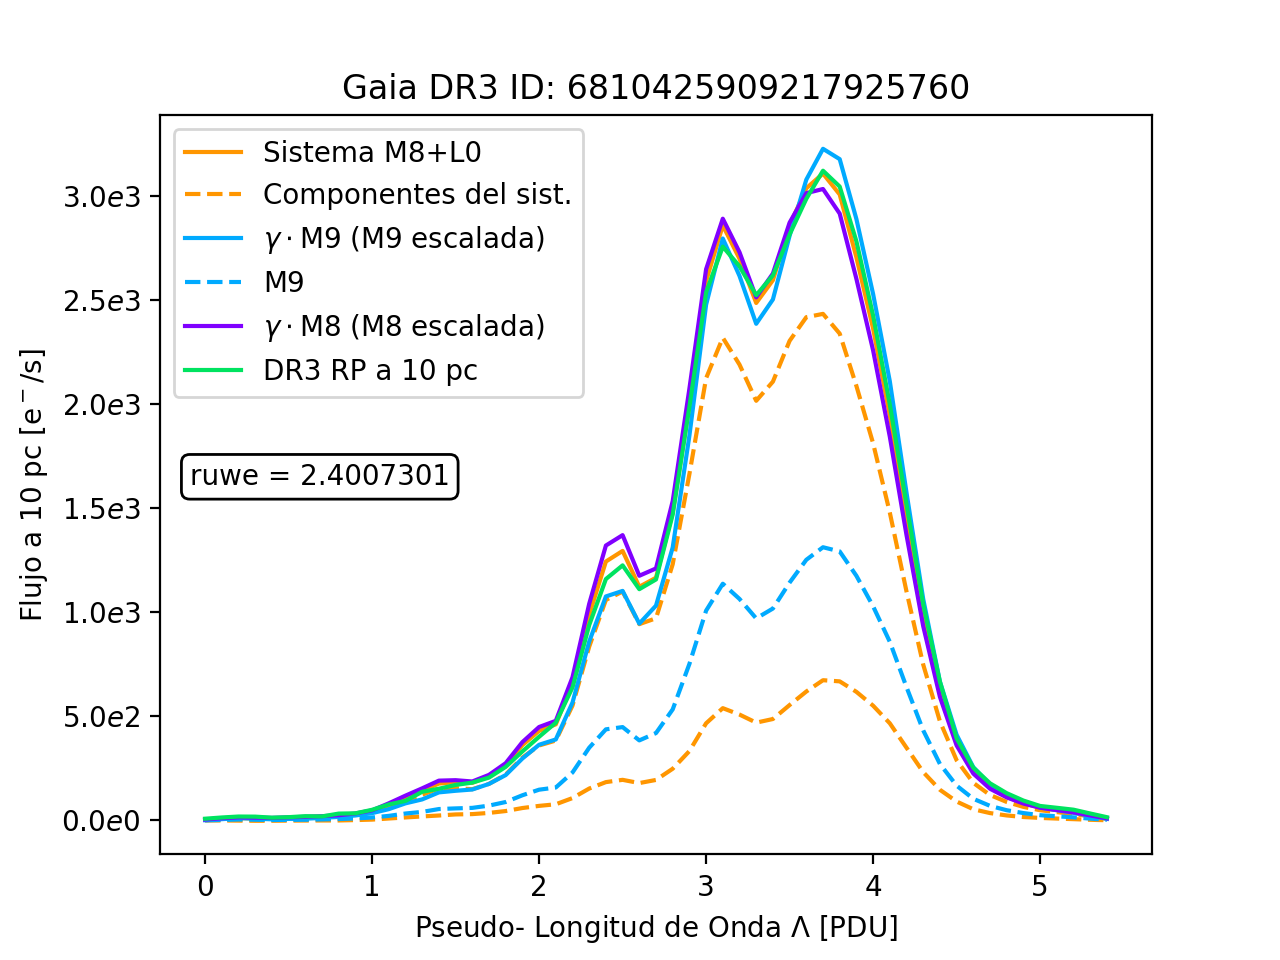

ID: 6810425909217925760
K = 61904.74009650871
ruwe = 2.4007301



1

In [10]:
ana(6810425909217925760)